In [157]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import cv2

In [158]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [159]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label



In [160]:
# chose 25 folders randomly
num_subject = 25
seed = 202311172359
chosen = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

# Load images 
images = []
labels = []

directory = Path("../ca2/data/PIE")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)

    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)

print(chosen)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


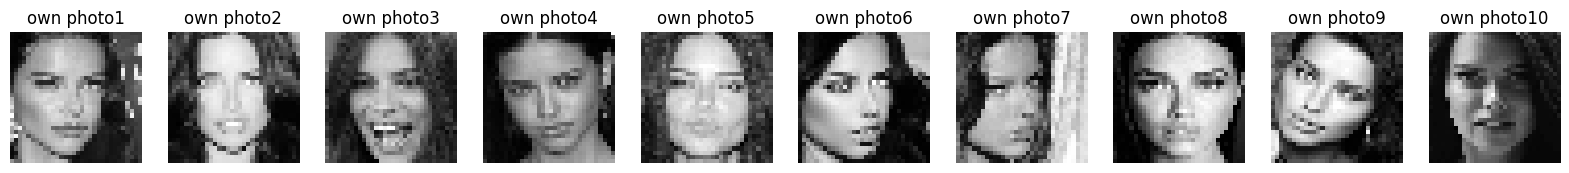

In [161]:
# process own photos
own_imgs = []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
    own_imgs.append(img)  # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69

# split training and testing data sets 
own_train_imgs = own_imgs[0:7]  # first 7 phots for training
own_test_imgs = own_imgs[7:]  # last 3 photos for testing
own_train_labels = own_labels[0:7]
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [162]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings

warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(num_subject * NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(num_subject * (170 - NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train, own_images_train, axis=0, )
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test, own_images_test, axis=0, )
full_test_labels = np.append(labels_test, own_labels_test)

In [163]:
sample_index = np.random.default_rng(2020).choice(np.arange(2982), 500, replace=False)

x_train = full_train_set[sample_index]
y_train = full_train_labels[sample_index]

In [164]:
class PCA:
    def __init__(self):
        pass

    def fit(self, X, n_components):
        X = X.reshape(-1, 32 * 32)
        mean_X = X.mean(axis=0)
        centered_X = X - mean_X

        u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
        s_matrix = np.diag(s)

        # max components: 200
        X_pca = u[:, :n_components] @ s_matrix[:n_components, :n_components]

        return u, s, vh, X_pca

In [165]:
pca = PCA()

In [166]:
u, s, vh, X_pca = pca.fit(x_train, 200)

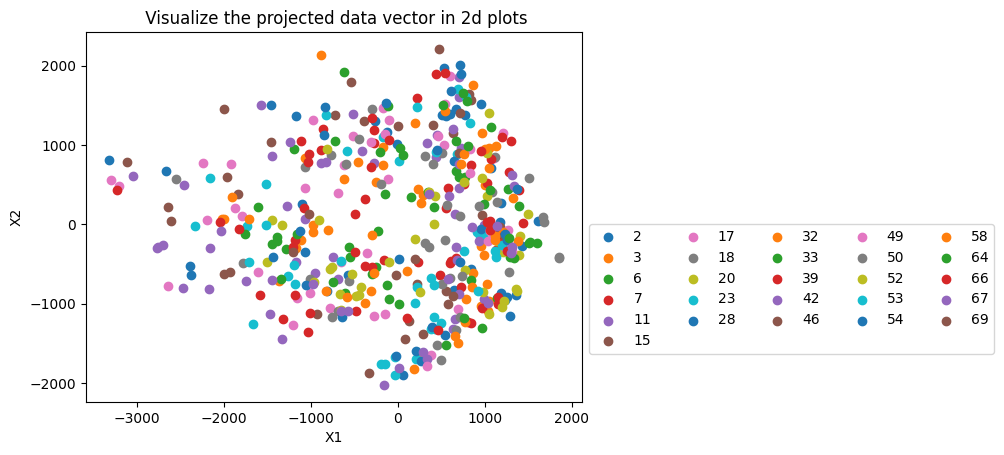

In [167]:
fig = plt.figure()
ax = fig.add_subplot()
for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], label=i)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
lgd = ax.legend(ncol=np.int_(num_subject / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

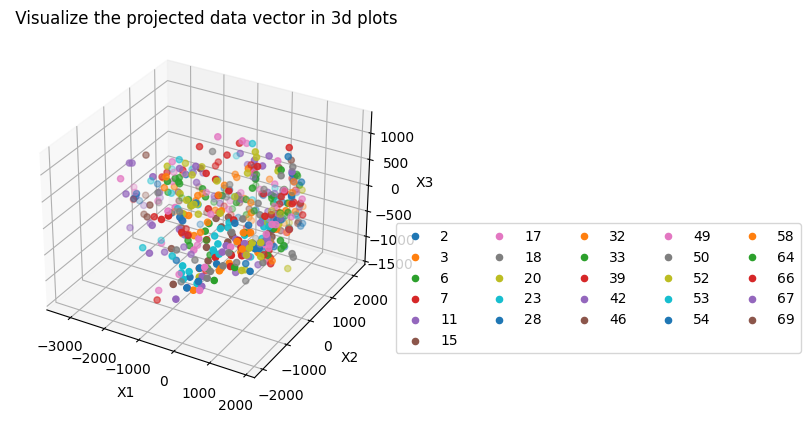

In [168]:
# 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], X_pca[y_train == i][:, 2], label=i, )

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

lgd = ax.legend(ncol=np.int_(num_subject / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 3d plots')
plt.show()

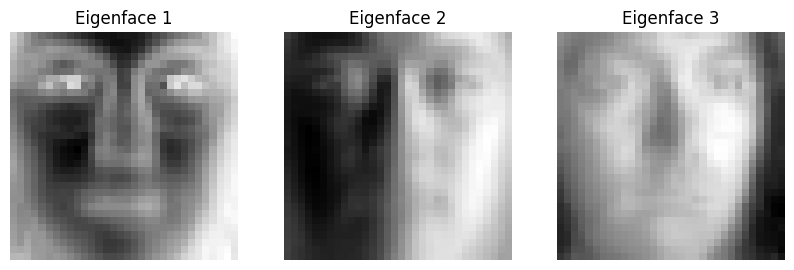

In [169]:
def ComputeEigenface(eigenface):
    normalized = (
            (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
    )
    return Image.fromarray(normalized.astype("uint8").reshape(32, 32), "L")


#===========================================
faces = 3
fig = plt.figure(figsize=(10, 10))
for i in range(faces):
    face = ComputeEigenface(vh[i])
    plt.subplot(1, 3, i + 1)
    plt.imshow(face, cmap='gray')
    plt.title('Eigenface ' + str(i + 1))
    plt.axis('off')
plt.show()

In [170]:
# Center test set (PIE)
mean_X_test = np.mean(images_test, axis=0)
centered_X_test = images_test - mean_X_test

# Center test set (own)
own_mean_X_test = np.mean(own_images_test, axis=0)
own_centered_X_test = own_images_test - own_mean_X_test

# PCA projection
X_pca_test = centered_X_test @ vh.T[:, :200]
own_X_pca_test = own_centered_X_test @ vh.T[:, :200]

In [171]:
def NN_classification(dim, X, y):
    dist_arr_test = np.linalg.norm(X[:, :dim][:, np.newaxis] - X_pca[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  # get the indices (cols) in sorted order

    k = 1  # Unique person
    # Get knn indices then use them to access label
    knn_indices = dist_arr_test[:, :k]
    knn_labels = y_train[knn_indices]

    # Original rows (X values we want to check) are preserved, so we apply
    # KNN formula to each row, but ignore k since its constant here
    result = knn_labels[:, 0]
    acc = np.sum(result == y) / y.size

    return acc


def Accuracy(X, y):
    for i in [40, 80, 200]:
        print(
            "Accuracy with dim",
            i,
            "=",
            NN_classification(i, X, y),
        )


#===================================================
print("For PIE:")
Accuracy(X_pca_test, labels_test)
print("For own photos:")
Accuracy(own_X_pca_test, own_labels_test)

For PIE:
Accuracy with dim 40 = 0.527843137254902
Accuracy with dim 80 = 0.5662745098039216
Accuracy with dim 200 = 0.5827450980392157
For own photos:
Accuracy with dim 40 = 0.0
Accuracy with dim 80 = 0.0
Accuracy with dim 200 = 0.0


# own dataset is too small, which can not influence the distribution of the training set